In [40]:
! wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
! wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
! pip install spectral

URL transformed to HTTPS due to an HSTS policy
--2023-12-01 16:32:30--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat.3’

Indian_pines_correc 100%[===================>]   5.68M  2.70MB/s    in 2.1s    

2023-12-01 16:32:33 (2.70 MB/s) - ‘Indian_pines_corrected.mat.3’ saved [5953527/5953527]

URL transformed to HTTPS due to an HSTS policy
--2023-12-01 16:32:33--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: ‘Indian_pines_gt.mat.3’

Indian_pines_gt.mat 100%[===================>]   1.1

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [41]:
class_num = 16
windowSize = 25
K = 30        #参考Hybrid-Spectral-Net
rate = 16

class HybridSN(nn.Module):
  #定义各个层的部分
  def __init__(self):
    super(HybridSN, self).__init__()
    self.S = windowSize
    self.L = K;

    #self.conv_block = nn.Sequential()
    ## convolutional layers
    self.conv1 = nn.Conv3d(in_channels=1, out_channels=8, kernel_size=(7, 3, 3))
    self.conv2 = nn.Conv3d(in_channels=8, out_channels=16, kernel_size=(5, 3, 3))
    self.conv3 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=(3, 3, 3))

    #不懂 inputX经过三重3d卷积的大小
    inputX = self.get2Dinput()
    inputConv4 = inputX.shape[1] * inputX.shape[2]
    # conv4 （24*24=576, 19, 19），64个 3x3 的卷积核 ==>（（64, 17, 17）
    self.conv4 = nn.Conv2d(inputConv4, 64, kernel_size=(3, 3))

    #self-attention
    self.sa1 = nn.Conv2d(64, 64//rate, kernel_size=1)
    self.sa2 = nn.Conv2d(64//rate, 64, kernel_size=1)

    # 全连接层（256个节点） # 64 * 17 * 17 = 18496
    self.dense1 = nn.Linear(18496, 256)
    # 全连接层（128个节点）
    self.dense2 = nn.Linear(256, 128)
    # 最终输出层(16个节点)
    self.dense3 = nn.Linear(128, class_num)

    #让某个神经元的激活值以一定的概率p，让其停止工作，这次训练过程中不更新权值，也不参加神经网络的计算。
    #但是它的权重得保留下来（只是暂时不更新而已），因为下次样本输入时它可能又得工作了
    #参考: https://blog.csdn.net/yangfengling1023/article/details/82911306
    #self.drop = nn.Dropout(p = 0.4)
    #改成0.43试试
    self.drop = nn.Dropout(p = 0.43)
    self.soft = nn.Softmax(dim=1)
    pass

  #辅助函数，没怎么懂，求经历过三重卷积后二维的一个大小
  def get2Dinput(self):
    #torch.no_grad(): 做运算，但不计入梯度记录
    with torch.no_grad():
      x = torch.zeros((1, 1, self.L, self.S, self.S))
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
    return x
    pass

  #必须重载的部分，X代表输入
  def forward(self, x):
    #F在上文有定义torch.nn.functional，是已定义好的一组名称
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = F.relu(self.conv3(out))

    # 进行二维卷积，因此把前面的 32*18 reshape 一下，得到 （576, 19, 19）
    out = out.view(-1, out.shape[1] * out.shape[2], out.shape[3], out.shape[4])
    out = F.relu(self.conv4(out))

    # Squeeze 第三维卷成1了
    weight = F.avg_pool2d(out, out.size(2))    #参数为输入，kernel
    #参考: https://blog.csdn.net/qq_21210467/article/details/81415300
    #参考: https://blog.csdn.net/u013066730/article/details/102553073

    # Excitation: sa（压缩到16分之一）--Relu--fc（激到之前维度）--Sigmoid（保证输出为0至1之间）
    weight = F.relu(self.sa1(weight))
    weight = F.sigmoid(self.sa2(weight))
    out = out * weight

    # flatten: 变为 18496 维的向量，
    out = out.view(out.size(0), -1)

    out = F.relu(self.dense1(out))
    out = self.drop(out)
    out = F.relu(self.dense2(out))
    out = self.drop(out)
    out = self.dense3(out)

    #添加此语句后出现LOSS不下降的情况，参考：https://www.e-learn.cn/topic/3733809
    #原因是CrossEntropyLoss()=softmax+负对数损失（已经包含了softmax)。如果多写一次softmax，则结果会发生错误
    #out = self.soft(out)
    #out = F.log_softmax(out)

    return out
    pass

In [42]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [43]:
# 地物类别
class_num = 16
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

# 用于测试样本的比例
test_ratio = 0.90
# 每个像素周围提取 patch 的尺寸
patch_size = 25
# 使用 PCA 降维，得到主成分的数量
pca_components = 30

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)

# 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
print('before transpose: Xtrain shape: ', Xtrain.shape)
print('before transpose: Xtest  shape: ', Xtest.shape)

# 为了适应 pytorch 结构，数据要做 transpose
Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
Xtest  = Xtest.transpose(0, 4, 3, 1, 2)
print('after transpose: Xtrain shape: ', Xtrain.shape)
print('after transpose: Xtest  shape: ', Xtest.shape)


""" Training dataset"""
class TrainDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self):
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self):
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=128, shuffle=False, num_workers=2)

Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)

... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 30)

... ... create data cubes ... ...
Data cube X shape:  (10249, 25, 25, 30)
Data cube y shape:  (10249,)

... ... create train & test data ... ...
Xtrain shape:  (1024, 25, 25, 30)
Xtest  shape:  (9225, 25, 25, 30)
before transpose: Xtrain shape:  (1024, 25, 25, 30, 1)
before transpose: Xtest  shape:  (9225, 25, 25, 30, 1)
after transpose: Xtrain shape:  (1024, 1, 30, 25, 25)
after transpose: Xtest  shape:  (9225, 1, 30, 25, 25)


In [34]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net = HybridSN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 开始训练
total_loss = 0
for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 优化器梯度归零
        optimizer.zero_grad()
        # 正向传播 +　反向传播 + 优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))

print('Finished Training')


[Epoch: 1]   [loss avg: 21.6202]   [current loss: 2.6145]
[Epoch: 2]   [loss avg: 20.8816]   [current loss: 2.4805]
[Epoch: 3]   [loss avg: 20.3424]   [current loss: 2.3533]
[Epoch: 4]   [loss avg: 19.9749]   [current loss: 2.3120]
[Epoch: 5]   [loss avg: 19.5735]   [current loss: 2.1936]
[Epoch: 6]   [loss avg: 19.1408]   [current loss: 2.0477]
[Epoch: 7]   [loss avg: 18.6832]   [current loss: 1.9281]
[Epoch: 8]   [loss avg: 18.2085]   [current loss: 1.8266]
[Epoch: 9]   [loss avg: 17.5722]   [current loss: 1.5004]
[Epoch: 10]   [loss avg: 16.8353]   [current loss: 1.1370]
[Epoch: 11]   [loss avg: 16.0522]   [current loss: 0.9786]
[Epoch: 12]   [loss avg: 15.2669]   [current loss: 0.5971]
[Epoch: 13]   [loss avg: 14.4738]   [current loss: 0.6510]
[Epoch: 14]   [loss avg: 13.7293]   [current loss: 0.4641]
[Epoch: 15]   [loss avg: 13.0668]   [current loss: 0.3769]
[Epoch: 16]   [loss avg: 12.4483]   [current loss: 0.2438]
[Epoch: 17]   [loss avg: 11.8729]   [current loss: 0.3562]
[Epoch

In [35]:
# import os
# #connect to self drive
# from google.colab import drive
# drive.mount('/content/drive')

# os.chdir('/content/drive/My Drive')
# torch.save(net.state_dict(), 'HybridSN.pth')
torch.save(net.state_dict(), '/content/HybridSN2.pth')

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# net = HybridSN()

# net.load_state_dict(torch.load('HybridSN2.pth'))
# net.to(device)
# net.eval()
# def test_mat(mat1, mat2, result_path):
#     # 用于测试样本的比例
#     test_ratio = 0.90
#     # 每个像素周围提取 patch 的尺寸
#     patch_size = 25
#     # 使用 PCA 降维，得到主成分的数量
#     pca_components = 30

#     # load the original image
#     X = sio.loadmat(mat1)
#     X = X[list(X.keys())[-1]]
#     y = sio.loadmat(mat2)
#     y = y[list(y.keys())[-1]]

#     height = y.shape[0]
#     width = y.shape[1]

#     X = applyPCA(X, numComponents=pca_components)
#     X = padWithZeros(X, patch_size // 2)

#     # 逐像素预测类别
#     outputs = np.zeros((height, width))
#     for i in range(height):
#         for j in range(width):
#             if int(y[i, j]) == 0:
#                 continue
#             else:
#                 image_patch = X[i:i + patch_size, j:j + patch_size, :]
#                 image_patch = image_patch.reshape(1, image_patch.shape[0], image_patch.shape[1], image_patch.shape[2],
#                                                   1)
#                 X_test_image = torch.FloatTensor(image_patch.transpose(0, 4, 3, 1, 2)).to(device)
#                 prediction = net(X_test_image)
#                 prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
#                 outputs[i][j] = prediction + 1
#         if i % 20 == 0:
#             print('... ... row ', i, ' handling ... ...')

#     predict_image = spectral.imshow(classes=outputs.astype(int), figsize=(5, 5))
#     drive.mount('/content/drive')

#     os.chdir('/content/drive/My Drive/')
#     plt.savefig(result_path)
#     return True

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = HybridSN()

net.load_state_dict(torch.load('HybridSN2.pth'))
net.to(device)
net.eval()
def pred(X,y,result_path):
  # load the original image
# X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
# y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

  height = y.shape[0]
  width = y.shape[1]

  X = applyPCA(X, numComponents= pca_components)
  X = padWithZeros(X, patch_size//2)

# 逐像素预测类别
  outputs = np.zeros((height,width))
  for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1)
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 4, 3, 1, 2)).to(device)
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction+1
    if i % 20 == 0:
        print('... ... row ', i, ' handling ... ...')
  predict_image = spectral.imshow(classes=outputs.astype(int), figsize=(5, 5))

In [ ]:
%cd /content
!ls


/content
HybridSN.pth		      Indian_pines_corrected.mat.2  Indian_pines_gt.mat.2
Indian_pines_corrected.mat    Indian_pines_gt.mat	    sample_data
Indian_pines_corrected.mat.1  Indian_pines_gt.mat.1


... ... row  0  handling ... ...
... ... row  20  handling ... ...
... ... row  40  handling ... ...
... ... row  60  handling ... ...
... ... row  80  handling ... ...
... ... row  100  handling ... ...
... ... row  120  handling ... ...
... ... row  140  handling ... ...


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


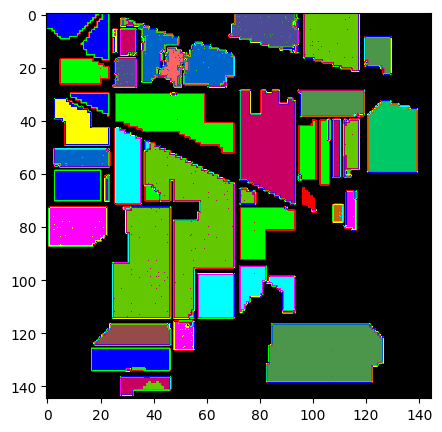

In [47]:

# source_1_path = 'media/source' + ''.join(str(mat1).split('.')[:-1]) + '.mat'
# source_2_path = 'media/source' + ''.join(str(mat2).split('.')[:-1]) + '.mat'
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']
source1='/content/Indian_pines_corrected.mat.2'
source2='/content/Indian_pines_gt.mat.2'
#result_path = 'content/' + ''.join(str(X).split('.')[:-1]) + '.png'
result_path="/content/result2.png"
# result = test_map(source1,source2,result_path)
pred(X,y,result_path)
# drive.mount('/content/drive')

# os.chdir('/content/drive/My Drive/')
# drive.mount("/content/drive", force_remount=True)
# plt.savefig(result_path)

In [ ]:
import os
print(os.getcwd())
#connect to self drive
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive')
torch.save(net.state_dict(), 'HybridSN.pth')
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())
count = 0
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

/content/drive/MyDrive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model's state_dict:
conv1.weight 	 torch.Size([8, 1, 7, 3, 3])
conv1.bias 	 torch.Size([8])
conv2.weight 	 torch.Size([16, 8, 5, 3, 3])
conv2.bias 	 torch.Size([16])
conv3.weight 	 torch.Size([32, 16, 3, 3, 3])
conv3.bias 	 torch.Size([32])
conv4.weight 	 torch.Size([64, 576, 3, 3])
conv4.bias 	 torch.Size([64])
sa1.weight 	 torch.Size([4, 64, 1, 1])
sa1.bias 	 torch.Size([4])
sa2.weight 	 torch.Size([64, 4, 1, 1])
sa2.bias 	 torch.Size([64])
dense1.weight 	 torch.Size([256, 18496])
dense1.bias 	 torch.Size([256])
dense2.weight 	 torch.Size([128, 256])
dense2.bias 	 torch.Size([128])
dense3.weight 	 torch.Size([16, 128])
dense3.bias 	 torch.Size([16])
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000        41
         1.0     0.0000    0.0000    0.0000      1285
         2.0     0.0810  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# load the original image
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

height = y.shape[0]
width = y.shape[1]

X = applyPCA(X, umnComponents= cap_components)
X = padWithZeros(X, patch_size//2)

# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1)
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 4, 3, 1, 2)).to(device)
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction+1
    if i % 20 == 0:
        print('... ... row ', i, ' handling ... ...')

NameError: ignored

/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


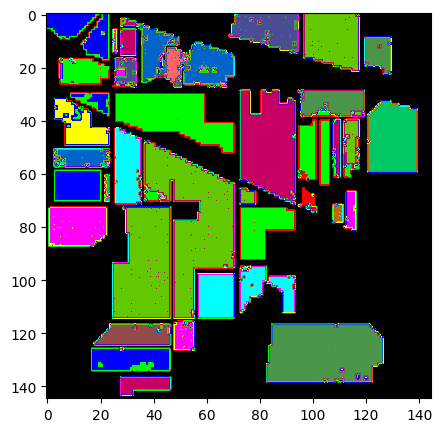

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))